# Collecting Data

In [1]:
import pandas as pd
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType

In [2]:
# the seasons we will be working with, END_YEAR not included (2009-10 through 2018-19) 

START_YEAR, END_YEAR = 2010, 2020 

In [4]:
for year in range(START_YEAR, END_YEAR):
    client.season_schedule(
        season_end_year=year, 
        output_type=OutputType.CSV, 
        output_file_path = "./Games/allgames%s.csv" % str(year)
    )

In [3]:
# compile all of the seasons into one list, and only include regular season games 

shortened_years = {
    2012: 990, 
    2013: 1229 
}

allgames = [pd.read_csv("./Games/allgames%s.csv" % (year)).iloc[range(0, 1230), :] if year not in shortened_years 
            else pd.read_csv("./Games/allgames%s.csv" % (year)).iloc[range(0, shortened_years[year]), :]  
            for year in range(START_YEAR, END_YEAR)]

In [4]:
# add column for home win
for game in allgames: 
    game["home_team_win?"] = game["home_team_score"] > game["away_team_score"]

    
# what is the home team win % over these 10 regular seasons? 
num_home_wins = sum([game["home_team_win?"].sum() for game in allgames]) 
num_games = sum([game.shape[0] for game in allgames])

home_win_percentage = num_home_wins / num_games 
print(home_win_percentage)

0.5896011277883738


# Finding Travel Distance Between Each Road Game

# Some Definitions: 
###### road trip: Any continuous stretch of away games directly following a home game (the length is the # of games played)
###### cumulative distance: Refers to the total distance traveled from game to game during a road trip 
###### n game road trip: A road trip of length n, where length is measured in the number of games played


#### Some Notes: 
###### An n game road trip may be a fraction of a larger road trip. For example, a 5 game road trip consists of a 4 game road trip, a 3 game road trip, etc...
###### Therefore, when I refer to a n game road trip, it does not imply that the n + 1 game is a home game. 
###### However, all road trips start from the first away game following a home game. For example, the last 3 games of a 5 game road trip is not a 3 game road trip. However, the first 3 games of a 5 game road trip is a 3 game road trip. 
###### All travel distances are approximated as the distance between the home cities of each team. For example, If the 76ers played an away  game against the Celtics, the distance traveled would be estimated as the distance between Philadelphia and Boston, according to this API: https://www.distance24.org/api.xhtml
###### I did not consider games played between the Clippers and Lakers in my calculations, as they share a stadium, which pretty much defeats the purpose of home v. away. 


In [5]:
# Map each team to its home city 

team_cities = {
    "PHILADELPHIA 76ERS": "Philadelphia" , 
    "LOS ANGELES LAKERS": "Los Angeles" , 
    "NEW ORLEANS PELICANS": "New Orleans" , 
    "PORTLAND TRAIL BLAZERS": "Portland" , 
    "PHOENIX SUNS": "Phoenix" , 
    "MEMPHIS GRIZZLIES": "Memphis",
    "SAN ANTONIO SPURS" : "San Antonio", 
    "WASHINGTON WIZARDS" : "Washington DC", 
    "CHARLOTTE HORNETS" : "Charlotte", 
    "ORLANDO MAGIC" : "Orlando", 
    "BOSTON CELTICS" : "Boston", 
    "INDIANA PACERS" : "Indiana", 
    "UTAH JAZZ" : "Salt Lake City", 
    "LOS ANGELES CLIPPERS": "Los Angeles", 
    "CHICAGO BULLS" : "Chicago", 
    "NEW YORK KNICKS": "New York City", 
    "BROOKLYN NETS": "Brooklyn", 
    "HOUSTON ROCKETS": "Houston", 
    "DALLAS MAVERICKS" : "Dallas", 
    "GOLDEN STATE WARRIORS": "San Francisco", 
    "MINNESOTA TIMBERWOLVES" : "Minneapolis", 
    "ATLANTA HAWKS" : "Atlanta", 
    "OKLAHOMA CITY THUNDER" : "Oklahoma City", 
    "MIAMI HEAT" : "Miami", 
    "DENVER NUGGETS" : "Denver", 
    "DETROIT PISTONS" : "Detroit", 
    "SACRAMENTO KINGS" : "Sacramento",  
    "TORONTO RAPTORS" : "Toronto", 
    "CLEVELAND CAVALIERS" : "Cleveland", 
    "MILWAUKEE BUCKS" : "Milwaukee",
    "NEW JERSEY NETS" : "East Rutherford", 
    "CHARLOTTE BOBCATS" : "Charlotte", 
    "NEW ORLEANS HORNETS" : "New Orleans" 
}

In [6]:
# Lets find out if winning an away game is correlated with distance traveled 
import json
import requests

class TeamTravelingVsWinning: 
    def __init__(self, team, year):
        # each object of this class will be associated with a unique NBA team and year 
        self.year = year 
        self.team = team  
        
        self.home_city = team_cities[team]  # city of the team 
        self.curr_city = team_cities[team]  # current location of the team (initialized to the home city)
        self.games_played = 0  # keeps track of the current game # 
        
        num_games = 82 if year != 2012 else 66 # only 66 games were played in the 2011-12 season
        
        if self.year == 2013:
            if self.team == "BOSTON CELTICS" or self.team == "INDIANA PACERS": # 1 game cancelled bc of boston marathon bombing  
                num_games = 81 
        
        #  As we iterate through the season's games, we will maintain this table for each team 
        self.table = {
            "cumulative_distance" : [0 for i in range(num_games)], 
            "n_game_road_trip" : [0 for i in range(num_games)], 
            "win?" : [None for i in range(num_games)]
        }
        
        # The teams dictionary will store a team for every (year, team) combination
        # Some combinations will be invalid, for instance the Charlotte Bobcats were not a team after 2013-14
        self.valid = False 
    
    def add_game(self, home_team, h_pnts, v_pnts):
        if  self.home_city != team_cities[home_team]: 
            cities = "stops=%s|%s" % (self.curr_city, team_cities[home_team])
            ep = "https://www.distance24.org/route.json?%s" % cities
            dist = requests.get(ep).json()["distance"]
            prev_road_count = self.table["n_game_road_trip"][self.games_played - 1]
            prev_cumulative_dist = self.table["cumulative_distance"][self.games_played - 1]
            self.table["n_game_road_trip"][self.games_played] = prev_road_count + 1 
            self.table["cumulative_distance"][self.games_played] = prev_cumulative_dist + dist 
        else: 
            self.table["n_game_road_trip"][self.games_played] = 0 
            self.table["cumulative_distance"][self.games_played] = 0 
        if self.team == home_team: 
            self.table["win?"][self.games_played] = 1 if h_pnts > v_pnts else 0 
        else: 
            self.table["win?"][self.games_played] = 0 if h_pnts > v_pnts else 1 
        self.valid = True # if this method is accessed, it means that this team is "valid" 
        self.games_played += 1  
        self.curr_city = team_cities[home_team] 

teams = {} 
for year in range(START_YEAR, END_YEAR): 
    for team in team_cities: 
        teams[(team, year)] = TeamTravelingVsWinning(team, year)


In [9]:
for year in range(START_YEAR, END_YEAR): 
    print(str((year - START_YEAR) / (END_YEAR - START_YEAR) * 100) + '% done')
    for row in allgames[year - START_YEAR].iterrows():
        visitor = row[1].loc["away_team"]
        home_team = row[1].loc["home_team"] 
        h_pnts = row[1].loc["home_team_score"] 
        v_pnts = row[1].loc["away_team_score"]
        teams[(visitor, year)].add_game(home_team, h_pnts, v_pnts) 
        teams[(home_team, year)].add_game(home_team, h_pnts, v_pnts) 

print("100% done")
        
        

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100% done


In [7]:
# Lets save each team's table as a csv, because that took a while to calculate 
dfs = {(team, year):pd.DataFrame.from_dict(data.table) for (team, year), data in teams.items() 
       if data.valid}
for (team, year), df in dfs.items(): 
    name = "%s%s.csv" % (team, year)
    path = 'TeamTravelDistVsWinning/%s' % name
    df.to_csv(path, index = False)


In [8]:
# Now, let's compile each teams data into one big DataFrame

team_travel_data = []
for year in range(START_YEAR, END_YEAR):
    for team, city in team_cities.items(): 
        file = "%s%s.csv" % (team, year) 
        try:
            team_travel_data.append(pd.read_csv('TeamTravelDistVsWinning/%s' % file))
        except FileNotFoundError: # not every team, city combination is a valid team 
            continue 

complete_data = pd.concat(team_travel_data)

# delete home games 
complete_data = complete_data[complete_data['n_game_road_trip'] > 0]

# get table sorted by distance
complete_data.sort_values(by = ['cumulative_distance', 'n_game_road_trip'], inplace = True)

# reset indices 
complete_data.reset_index(drop=True, inplace=True)

complete_data['cumulative_distance'].describe()
# complete_data['n_game_road_trip'].describe()


count    11497.000000
mean      2553.096199
std       1886.785187
min          8.000000
25%       1067.000000
50%       2061.000000
75%       3635.000000
max      13039.000000
Name: cumulative_distance, dtype: float64

In [11]:
# Save complete_data as a csv 

complete_data.to_csv("CompleteData/completedata.csv")

# Analysis

In [46]:
# Explore sample size for each road trip length for different values of n 

complete_data = pd.read_csv("CompleteData/completedata.csv")

print("sample size for different values of n, where n is the length of a road trip")
for i in range(1, 11):
    print("n = %s:" % str(i), complete_data[complete_data['n_game_road_trip'] == i].shape[0])

sample size for different values of n, where n is the length of a road trip
n = 1: 5699
n = 2: 2902
n = 3: 1517
n = 4: 778
n = 5: 360
n = 6: 153
n = 7: 56
n = 8: 23
n = 9: 8
n = 10: 1


In [47]:
# We have to figure out a way to bin this data 
# It makes the most sense to do bins of 1, 2, 3, 4, 5, 6 and > 6 so each bin is sufficiently large

AWAY_WIN_PERCENTAGE = 1 - home_win_percentage 

data_dict = {
    "sample size": [],
    "nth game of road trip": [],
    "mean travel distance" : [],
    "games won" : [], 
    "expected games won" : [], # if winning is independent of the length of road trip, how many games should be won? 
    "win %" : []
}
for i in range(1, 11): 
    data = complete_data[complete_data['n_game_road_trip'] == i]
    games_won = int(data['win?'].sum()) 
    size = data.shape[0] 
    winpercentage = games_won / i_size
    mean_traveldist = data["cumulative_distance"].mean()
    data_dict["sample size"].append(size)
    data_dict["win %"].append(winpercentage)
    data_dict["nth game of road trip"].append(i) 
    data_dict["mean travel distance"].append(mean_traveldist)
    data_dict["games won"].append(games_won) 
    data_dict["expected games won"].append(int(size * AWAY_WIN_PERCENTAGE))

wins_vs_roadtrip = pd.DataFrame.from_dict(data_dict) 
    
display(wins_vs_roadtrip) 

,sample size,nth game of road trip,mean travel distance,games won,expected games won,win %
0,5699,1,1300.371469,2334,2338,2334.0
1,2902,2,2667.374569,1163,1190,1163.0
2,1517,3,3945.589980,610,622,610.0
3,778,4,5204.464010,313,319,313.0
4,360,5,6247.044444,161,147,161.0
5,153,6,7342.411765,68,62,68.0
6,56,7,8497.160714,24,22,24.0
7,23,8,9692.956522,11,9,11.0
8,8,9,10707.125000,3,3,3.0
9,1,10,10115.000000,0,0,0.0


In [48]:
# is this data significant?

from scipy.stats import chisquare

observed = data_dict['games won'][0:6] 
observed.append(sum(data_dict['games won'][6:])) # combine the smaller sample sizes
expected = data_dict['expected games won'][0:6]
expected.append(sum(data_dict['expected games won'][6:])) # combine the smaller sample sizes

print(observed, expected)
results = chisquare(observed, expected)

print(results) 

# According to this test, probably not 
# However, this was probably not the best test to use 

[2334, 1163, 610, 313, 161, 68, 38] [2338, 1190, 622, 319, 147, 62, 34]
Power_divergenceResult(statistic=3.348379146475928, pvalue=0.7640205652076703)


From the eye test, there seems to be a potentially significant jump in win % when a team is on their 5th or greater game of a road trip. Let's see if that is true using a difference of proportions test, with the two proportions being the wins during the nth game of the road trip for 1 <= n <= 4, and the wins for 5 <= n <= 10. 

In [49]:
import scipy.stats as st

def diff_of_proportions_test(y1, n1, y2, n2): 
    p1, p2 = y1 / n1, y2 / n2 
    p0 = (y1 + y2) / (n1 + n2)
    z_obs = (p1 - p2) / ((p0 * (1 - p0) * (1/n1 + 1/n2)) ** .5) 
    return 1 - st.norm.cdf(z_obs) 
    

In [50]:
p1_wins = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] <= 4]['games won'].sum()
p1_games = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] <= 4]['sample size'].sum()

p2_wins = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] > 4]['games won'].sum()
p2_games = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] > 4]['sample size'].sum()

p_value = diff_of_proportions_test(p2_wins, p2_games, p1_wins, p1_games)
p_value

0.03039729368480515

That p value means that there is only a 3% chance that the discrepancy in the two proportions occured by random chance! This means, fairly definitively, that after the 4th game of a road trip teams are more likely to win. 

# Longest Road Trip? Longest Distance Traveled?

We know that the longest road trip was 10 games, and the longest distance traveled was 13039 km. 

But which teams endured these massive road trips? If I was smarter, I would have added a column for "team" and "year" before I mixed up the data, but I didn't, so now we have to write some more code :)

In [15]:
team_longest_dist, team_longest_road_trip = None, None 

for year in range(START_YEAR, END_YEAR):
    for team, city in team_cities.items(): 
        
        file = "%s%s.csv" % (team, year) 
        try:
            team_season = pd.read_csv('TeamTravelDistVsWinning/%s' % file)
        except FileNotFoundError: # not every team, city combination is a valid team 
            continue 
        
        if team_season[team_season["n_game_road_trip"] == 10].shape[0] != 0:
            team_longest_road_trip = (team, year) 
        if team_season[team_season["cumulative_distance"] == 13039].shape[0] != 0: 
            team_longest_dist = (team, year)
            

print("Longest Distance Traveled: %s" % str(team_longest_dist))            
print("Longest Road Trip: %s" % str(team_longest_road_trip))

Longest Distance Traveled: ('PHILADELPHIA 76ERS', 2011)
Longest Road Trip: ('LOS ANGELES CLIPPERS', 2011)


Technically, the Clippers 10 game road trip was actually 11 games! The 11th game was against the Lakers, but I didn't count games between the Clippers and Lakers in my calculations (as I said before, they share a stadium, which defeats the purpose of analyzing the effects of away games). 

# Visualizations

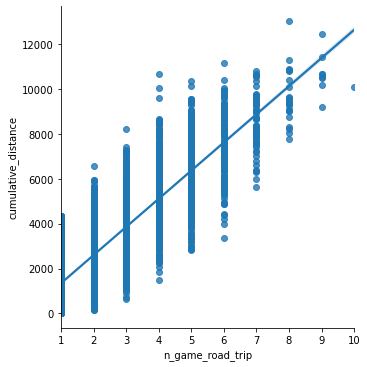

In [16]:
# Visualization of distance traveled vs length of trip 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x = "n_game_road_trip", y = "cumulative_distance", data = complete_data)


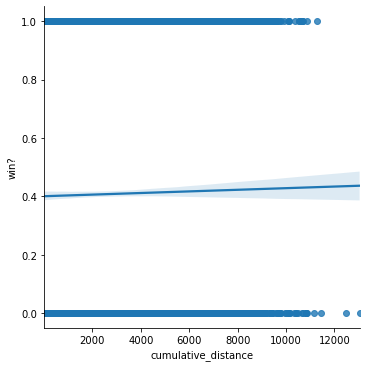

In [20]:
sns.lmplot(x = "cumulative_distance", y = "win?", data = complete_data)